# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 'primary_immune'
TITRATING_CELLTYPE = 'Blueprint-B'
TITRATING_CELLTYPE_ATLAS = 'immune_b' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 2 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 1000000

# make sure the orders of the two list match
CELLTYPES = ['Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-B', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']
ABRIDGED_NAMES = ['CD4', 'CD8', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.2, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]
TITRATION_LIST=[0.2, 0.15]

# proportion of cells in real whole blood (sum to 1)
WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
                         'Blueprint-Mono':0.09,
                         'Blueprint-Neutro':0.57,
                         'Blueprint-CD4':0.16,
                         'Blueprint-CD8':0.07,
                         'Blueprint-NK':0.05}
    

In [2]:
# Parameters
ROOT_DIR = "/analysis/gh-msun/"
PROJECT_SLUG = "2023_06_26_SRT_deconvolution_MS"
EXPERIMENT = "primary_immune"
TITRATING_CELLTYPE = "Blueprint-Mono"
TITRATING_CELLTYPE_ATLAS = "immune_dend_plus_macro_plus_mono"
BACKGROUND = "wholeblood"
N_REPLICATES = 20
SEED = 960318
TOTAL_READS_TO_SAMPLE = 1000000
CELLTYPES = ["Blueprint-CD4", "Blueprint-CD8", "Blueprint-B", "Blueprint-NK", "Blueprint-Mono", "Blueprint-Neutro"]
ABRIDGED_NAMES = ["CD4", "CD8", "B", "NK", "MONO", "NEUTRO"]
TITRATION_LIST = [0.2, 0.15, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001, 0]
WHOLE_BLOOD_ABUNDANCE = {"Blueprint-B": 0.06, "Blueprint-Mono": 0.09, "Blueprint-Neutro": 0.57, "Blueprint-CD4": 0.16, "Blueprint-CD8": 0.07, "Blueprint-NK": 0.05}


In [3]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [4]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [6]:
#################################
#   Set titration proportions   #
#################################

# Reorder such that the titrating cell type comes first
CELLTYPES_unordered = CELLTYPES.copy()
CELLTYPES = hlpr.titration_reordering(list_of_cell_types=CELLTYPES, 
                                      titrating_cell_type=TITRATING_CELLTYPE)

# Reorder abridged name
ABRIDGED_NAMES = hlpr.reorder_abridged_name(unordered_celltypes=CELLTYPES_unordered,
                                            ordered_celltypes=CELLTYPES,
                                            unordered_abridged_names=ABRIDGED_NAMES)
    
# set titration proportions
if BACKGROUND == 'uniform':
    PROPORTIONS = hlpr.generate_uniform_background_proportions(titration_list=TITRATION_LIST, 
                                                               cell_types=CELLTYPES)

if BACKGROUND == 'wholeblood':
    PROPORTIONS = hlpr.generate_custom_background_proportions(titration_list=TITRATION_LIST, 
                                                              custom_proportion=WHOLE_BLOOD_ABUNDANCE, 
                                                              list_of_celltypes=CELLTYPES, 
                                                              titrating_celltype=TITRATING_CELLTYPE)

PROPORTIONS[0]    

[0.2,
 0.1406593406593407,
 0.061538461538461556,
 0.052747252747252754,
 0.043956043956043966,
 0.5010989010989011]

## Create mixture

In [7]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [8]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: Blueprint-Mono


----------> Loading cell type: Blueprint-CD4


----------> Loading cell type: Blueprint-CD8


----------> Loading cell type: Blueprint-B


----------> Loading cell type: Blueprint-NK


----------> Loading cell type: Blueprint-Neutro


>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.2, 0.1406593406593407, 0.061538461538461556, 0.052747252747252754, 0.043956043956043966, 0.5010989010989011]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.15, 0.14945054945054945, 0.0653846153846154, 0.056043956043956046, 0.046703296703296704, 0.5324175824175824]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.1, 0.15824175824175826, 0.06923076923076925, 0.059340659340659345, 0.049450549450549455, 0.5637362637362637]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.08, 0.16175824175824177, 0.07076923076923079, 0.060659340659340664, 0.05054945054945056, 0.5762637362637363]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.06, 0.16527472527472528, 0.07230769230769232, 0.06197802197802198, 0.05164835164835165, 0.5887912087912087]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.04, 0.1687912087912088, 0.07384615384615387, 0.0632967032967033, 0.052747252747252754, 0.6013186813186813]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.02, 0.17230769230769233, 0.0753846153846154, 0.06461538461538462, 0.05384615384615385, 0.6138461538461538]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.01, 0.17406593406593407, 0.07615384615384617, 0.06527472527472528, 0.054395604395604404, 0.6201098901098901]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.008, 0.17441758241758243, 0.07630769230769233, 0.06540659340659341, 0.05450549450549451, 0.6213626373626373]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.006, 0.1747692307692308, 0.07646153846153848, 0.06553846153846155, 0.05461538461538462, 0.6226153846153846]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.004, 0.17512087912087915, 0.07661538461538463, 0.06567032967032967, 0.05472527472527473, 0.6238681318681318]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.002, 0.17547252747252748, 0.07676923076923078, 0.0658021978021978, 0.05483516483516484, 0.6251208791208791]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0.001, 0.17564835164835166, 0.07684615384615387, 0.06586813186813187, 0.054890109890109895, 0.6257472527472527]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


--> PROPORTION: [0, 0.17582417582417584, 0.07692307692307694, 0.06593406593406594, 0.05494505494505495, 0.6263736263736264]
----------> Creating mixture 0... 


----------> Creating mixture 1... 


----------> Creating mixture 2... 


----------> Creating mixture 3... 


----------> Creating mixture 4... 


----------> Creating mixture 5... 


----------> Creating mixture 6... 


----------> Creating mixture 7... 


----------> Creating mixture 8... 


----------> Creating mixture 9... 


----------> Creating mixture 10... 


----------> Creating mixture 11... 


----------> Creating mixture 12... 


----------> Creating mixture 13... 


----------> Creating mixture 14... 


----------> Creating mixture 15... 


----------> Creating mixture 16... 


----------> Creating mixture 17... 


----------> Creating mixture 18... 


----------> Creating mixture 19... 


>>> Complete. <<< 

CPU times: user 1.45 s, sys: 298 ms, total: 1.75 s
Wall time: 23min 33s


## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')

In [11]:
%%time
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 14.7 s, sys: 5.07 s, total: 19.8 s
Wall time: 19.8 s


In [12]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)

region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [13]:
ridxs = ~region_df['region_cpg_index_min_hg38'].isna()
ridxs &= ~region_df['region_cpg_index_max_hg38'].isna()
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1658, 1658)

In [14]:
cg_count_hg19 = region_df['region_cpg_index_max']-region_df['region_cpg_index_min'] + 1
cg_count_hg38 = region_df['region_cpg_index_max_hg38']-region_df['region_cpg_index_min_hg38'] + 1
ridxs = (cg_count_hg19==cg_count_hg38)
ridxs &= (cg_count_hg19>=FILTER_CG_COUNT_REGION)
region_df = region_df[ridxs].copy()
region_df.shape[0], region_df['region_id'].nunique()

(1657, 1657)

In [15]:
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min_hg38'].astype(int)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max_hg38'].astype(int)

In [16]:
### Restrict to immune regions
#-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# BLUEPRINT immune regions
ATLAS_PATH = PROJECT_DIR + f'/output/reference/deconv_inhouse_v2.atlas.tsv.gz'
atlas = pd.read_csv(ATLAS_PATH, sep='\t')
subset_region_set = set(atlas.region_id)
#-----------------------------------------------------------------------------

# filter regions down to regions of interest
region_df = region_df[region_df['region_id'].isin(subset_region_set)]
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id,region_cpg_index_min_hg38,region_cpg_index_max_hg38
0,chr1,1114771,1114971,20117,20129,Immune_Broad_B-chr1:1114772-1114971,21119,21131
1,chr1,1157450,1157720,21684,21703,Immune_Broad_NK-chr1:1157451-1157720,22686,22705
2,chr1,1157879,1158277,21710,21726,Immune_Broad_NK-chr1:1157880-1158277,22712,22728
14,chr1,6341182,6341377,140667,140681,Immune_Broad_Eosi-chr1:6341183-6341377,142368,142382
19,chr1,9147788,9147871,188605,188608,Immune_Broad_Neutro-chr1:9147789-9147871,190307,190310


In [17]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       region_df = region_df, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E2MONO_E1407CD4_E0615CD8_E0527B_E044NK_E5011NEUTRO
--------> Computing score matrix for mix0_seed419876


--------> Computing score matrix for mix1_seed135523


--------> Computing score matrix for mix2_seed394025


--------> Computing score matrix for mix3_seed669227


--------> Computing score matrix for mix4_seed684263


--------> Computing score matrix for mix5_seed293089


--------> Computing score matrix for mix6_seed256177


--------> Computing score matrix for mix7_seed435448


--------> Computing score matrix for mix8_seed492243


--------> Computing score matrix for mix9_seed147997


--------> Computing score matrix for mix10_seed729033


--------> Computing score matrix for mix11_seed968910


--------> Computing score matrix for mix12_seed988958


--------> Computing score matrix for mix13_seed950422


--------> Computing score matrix for mix14_seed860687


--------> Computing score matrix for mix15_seed923680


--------> Computing score matrix for mix16_seed435902


--------> Computing score matrix for mix17_seed410372


--------> Computing score matrix for mix18_seed583750


--------> Computing score matrix for mix19_seed182158




--> E15MONO_E1495CD4_E0654CD8_E056B_E0467NK_E5324NEUTRO
--------> Computing score matrix for mix0_seed956377


--------> Computing score matrix for mix1_seed787515


--------> Computing score matrix for mix2_seed956686


--------> Computing score matrix for mix3_seed114553


--------> Computing score matrix for mix4_seed483984


--------> Computing score matrix for mix5_seed923915


--------> Computing score matrix for mix6_seed884279


--------> Computing score matrix for mix7_seed197795


--------> Computing score matrix for mix8_seed203703


--------> Computing score matrix for mix9_seed991952


--------> Computing score matrix for mix10_seed899951


--------> Computing score matrix for mix11_seed204613


--------> Computing score matrix for mix12_seed495430


--------> Computing score matrix for mix13_seed234729


--------> Computing score matrix for mix14_seed948291


--------> Computing score matrix for mix15_seed549335


--------> Computing score matrix for mix16_seed376886


--------> Computing score matrix for mix17_seed113721


--------> Computing score matrix for mix18_seed660672


--------> Computing score matrix for mix19_seed626773




--> E1MONO_E1582CD4_E0692CD8_E0593B_E0495NK_E5637NEUTRO
--------> Computing score matrix for mix0_seed845201


--------> Computing score matrix for mix1_seed269032


--------> Computing score matrix for mix2_seed215354


--------> Computing score matrix for mix3_seed350861


--------> Computing score matrix for mix4_seed815603


--------> Computing score matrix for mix5_seed8837


--------> Computing score matrix for mix6_seed407246


--------> Computing score matrix for mix7_seed306008


--------> Computing score matrix for mix8_seed184113


--------> Computing score matrix for mix9_seed78729


--------> Computing score matrix for mix10_seed249749


--------> Computing score matrix for mix11_seed854160


--------> Computing score matrix for mix12_seed731381


--------> Computing score matrix for mix13_seed141781


--------> Computing score matrix for mix14_seed342643


--------> Computing score matrix for mix15_seed92043


--------> Computing score matrix for mix16_seed646127


--------> Computing score matrix for mix17_seed274719


--------> Computing score matrix for mix18_seed608253


--------> Computing score matrix for mix19_seed515150




--> E08MONO_E1618CD4_E0708CD8_E0607B_E0505NK_E5763NEUTRO
--------> Computing score matrix for mix0_seed606723


--------> Computing score matrix for mix1_seed837688


--------> Computing score matrix for mix2_seed932708


--------> Computing score matrix for mix3_seed240813


--------> Computing score matrix for mix4_seed208657


--------> Computing score matrix for mix5_seed431154


--------> Computing score matrix for mix6_seed322211


--------> Computing score matrix for mix7_seed944955


--------> Computing score matrix for mix8_seed631634


--------> Computing score matrix for mix9_seed613618


--------> Computing score matrix for mix10_seed852644


--------> Computing score matrix for mix11_seed342338


--------> Computing score matrix for mix12_seed896943


--------> Computing score matrix for mix13_seed880813


--------> Computing score matrix for mix14_seed732073


--------> Computing score matrix for mix15_seed278581


--------> Computing score matrix for mix16_seed143275


--------> Computing score matrix for mix17_seed651839


--------> Computing score matrix for mix18_seed714995


--------> Computing score matrix for mix19_seed432807




--> E06MONO_E1653CD4_E0723CD8_E062B_E0516NK_E5888NEUTRO
--------> Computing score matrix for mix0_seed814244


--------> Computing score matrix for mix1_seed93051


--------> Computing score matrix for mix2_seed362606


--------> Computing score matrix for mix3_seed243022


--------> Computing score matrix for mix4_seed693665


--------> Computing score matrix for mix5_seed908196


--------> Computing score matrix for mix6_seed946830


--------> Computing score matrix for mix7_seed720605


--------> Computing score matrix for mix8_seed495724


--------> Computing score matrix for mix9_seed809152


--------> Computing score matrix for mix10_seed494787


--------> Computing score matrix for mix11_seed91478


--------> Computing score matrix for mix12_seed619310


--------> Computing score matrix for mix13_seed929467


--------> Computing score matrix for mix14_seed776948


--------> Computing score matrix for mix15_seed870715


--------> Computing score matrix for mix16_seed572423


--------> Computing score matrix for mix17_seed681001


--------> Computing score matrix for mix18_seed80497


--------> Computing score matrix for mix19_seed294760




--> E04MONO_E1688CD4_E0738CD8_E0633B_E0527NK_E6013NEUTRO
--------> Computing score matrix for mix0_seed545458


--------> Computing score matrix for mix1_seed74553


--------> Computing score matrix for mix2_seed725036


--------> Computing score matrix for mix3_seed858082


--------> Computing score matrix for mix4_seed378129


--------> Computing score matrix for mix5_seed703716


--------> Computing score matrix for mix6_seed949541


--------> Computing score matrix for mix7_seed826552


--------> Computing score matrix for mix8_seed171082


--------> Computing score matrix for mix9_seed23469


--------> Computing score matrix for mix10_seed370680


--------> Computing score matrix for mix11_seed310016


--------> Computing score matrix for mix12_seed45811


--------> Computing score matrix for mix13_seed566980


--------> Computing score matrix for mix14_seed15581


--------> Computing score matrix for mix15_seed851315


--------> Computing score matrix for mix16_seed514371


--------> Computing score matrix for mix17_seed700473


--------> Computing score matrix for mix18_seed581470


--------> Computing score matrix for mix19_seed581519




--> E02MONO_E1723CD4_E0754CD8_E0646B_E0538NK_E6138NEUTRO
--------> Computing score matrix for mix0_seed5527


--------> Computing score matrix for mix1_seed88236


--------> Computing score matrix for mix2_seed492538


--------> Computing score matrix for mix3_seed541877


--------> Computing score matrix for mix4_seed993073


--------> Computing score matrix for mix5_seed910277


--------> Computing score matrix for mix6_seed764800


--------> Computing score matrix for mix7_seed959529


--------> Computing score matrix for mix8_seed87741


--------> Computing score matrix for mix9_seed904230


--------> Computing score matrix for mix10_seed887572


--------> Computing score matrix for mix11_seed88302


--------> Computing score matrix for mix12_seed499409


--------> Computing score matrix for mix13_seed443471


--------> Computing score matrix for mix14_seed587922


--------> Computing score matrix for mix15_seed25309


--------> Computing score matrix for mix16_seed21079


--------> Computing score matrix for mix17_seed627471


--------> Computing score matrix for mix18_seed403363


--------> Computing score matrix for mix19_seed639927




--> E01MONO_E1741CD4_E0762CD8_E0653B_E0544NK_E6201NEUTRO
--------> Computing score matrix for mix0_seed75714


--------> Computing score matrix for mix1_seed993132


--------> Computing score matrix for mix2_seed977136


--------> Computing score matrix for mix3_seed658241


--------> Computing score matrix for mix4_seed161394


--------> Computing score matrix for mix5_seed558581


--------> Computing score matrix for mix6_seed763486


--------> Computing score matrix for mix7_seed213986


--------> Computing score matrix for mix8_seed492497


--------> Computing score matrix for mix9_seed21163


--------> Computing score matrix for mix10_seed625206


--------> Computing score matrix for mix11_seed843111


--------> Computing score matrix for mix12_seed66789


--------> Computing score matrix for mix13_seed544153


--------> Computing score matrix for mix14_seed887873


--------> Computing score matrix for mix15_seed215106


--------> Computing score matrix for mix16_seed365016


--------> Computing score matrix for mix17_seed468468


--------> Computing score matrix for mix18_seed72772


--------> Computing score matrix for mix19_seed366578




--> E008MONO_E1744CD4_E0763CD8_E0654B_E0545NK_E6214NEUTRO
--------> Computing score matrix for mix0_seed317406


--------> Computing score matrix for mix1_seed123967


--------> Computing score matrix for mix2_seed110621


--------> Computing score matrix for mix3_seed565896


--------> Computing score matrix for mix4_seed644254


--------> Computing score matrix for mix5_seed127503


--------> Computing score matrix for mix6_seed973102


--------> Computing score matrix for mix7_seed166351


--------> Computing score matrix for mix8_seed844133


--------> Computing score matrix for mix9_seed620412


--------> Computing score matrix for mix10_seed106072


--------> Computing score matrix for mix11_seed50134


--------> Computing score matrix for mix12_seed761657


--------> Computing score matrix for mix13_seed330474


--------> Computing score matrix for mix14_seed535152


--------> Computing score matrix for mix15_seed806642


--------> Computing score matrix for mix16_seed520095


--------> Computing score matrix for mix17_seed487876


--------> Computing score matrix for mix18_seed347167


--------> Computing score matrix for mix19_seed70805




--> E006MONO_E1748CD4_E0765CD8_E0655B_E0546NK_E6226NEUTRO
--------> Computing score matrix for mix0_seed130065


--------> Computing score matrix for mix1_seed683126


--------> Computing score matrix for mix2_seed788402


--------> Computing score matrix for mix3_seed631751


--------> Computing score matrix for mix4_seed902323


--------> Computing score matrix for mix5_seed616517


--------> Computing score matrix for mix6_seed300030


--------> Computing score matrix for mix7_seed617160


--------> Computing score matrix for mix8_seed120107


--------> Computing score matrix for mix9_seed135997


--------> Computing score matrix for mix10_seed443736


--------> Computing score matrix for mix11_seed90319


--------> Computing score matrix for mix12_seed580340


--------> Computing score matrix for mix13_seed935268


--------> Computing score matrix for mix14_seed846489


--------> Computing score matrix for mix15_seed48825


--------> Computing score matrix for mix16_seed922509


--------> Computing score matrix for mix17_seed783347


--------> Computing score matrix for mix18_seed994576


--------> Computing score matrix for mix19_seed316253




--> E004MONO_E1751CD4_E0766CD8_E0657B_E0547NK_E6239NEUTRO
--------> Computing score matrix for mix0_seed428748


--------> Computing score matrix for mix1_seed324239


--------> Computing score matrix for mix2_seed366998


--------> Computing score matrix for mix3_seed673721


--------> Computing score matrix for mix4_seed316473


--------> Computing score matrix for mix5_seed457588


--------> Computing score matrix for mix6_seed482681


--------> Computing score matrix for mix7_seed993304


--------> Computing score matrix for mix8_seed497298


--------> Computing score matrix for mix9_seed533187


--------> Computing score matrix for mix10_seed723225


--------> Computing score matrix for mix11_seed800241


--------> Computing score matrix for mix12_seed271200


--------> Computing score matrix for mix13_seed710461


--------> Computing score matrix for mix14_seed869562


--------> Computing score matrix for mix15_seed338505


--------> Computing score matrix for mix16_seed987583


--------> Computing score matrix for mix17_seed373792


--------> Computing score matrix for mix18_seed383725


--------> Computing score matrix for mix19_seed844558




--> E002MONO_E1755CD4_E0768CD8_E0658B_E0548NK_E6251NEUTRO
--------> Computing score matrix for mix0_seed299748


--------> Computing score matrix for mix1_seed705308


--------> Computing score matrix for mix2_seed607878


--------> Computing score matrix for mix3_seed45599


--------> Computing score matrix for mix4_seed492728


--------> Computing score matrix for mix5_seed28202


--------> Computing score matrix for mix6_seed885145


--------> Computing score matrix for mix7_seed389487


--------> Computing score matrix for mix8_seed393496


--------> Computing score matrix for mix9_seed565834


--------> Computing score matrix for mix10_seed603538


--------> Computing score matrix for mix11_seed834468


--------> Computing score matrix for mix12_seed705903


--------> Computing score matrix for mix13_seed39463


--------> Computing score matrix for mix14_seed767226


--------> Computing score matrix for mix15_seed426740


--------> Computing score matrix for mix16_seed875938


--------> Computing score matrix for mix17_seed70582


--------> Computing score matrix for mix18_seed211845


--------> Computing score matrix for mix19_seed106456




--> E001MONO_E1756CD4_E0768CD8_E0659B_E0549NK_E6257NEUTRO
--------> Computing score matrix for mix0_seed940087


--------> Computing score matrix for mix1_seed818873


--------> Computing score matrix for mix2_seed771897


--------> Computing score matrix for mix3_seed771044


--------> Computing score matrix for mix4_seed197909


--------> Computing score matrix for mix5_seed716041


--------> Computing score matrix for mix6_seed977527


--------> Computing score matrix for mix7_seed813819


--------> Computing score matrix for mix8_seed570572


--------> Computing score matrix for mix9_seed470507


--------> Computing score matrix for mix10_seed547103


--------> Computing score matrix for mix11_seed892773


--------> Computing score matrix for mix12_seed865960


--------> Computing score matrix for mix13_seed620201


--------> Computing score matrix for mix14_seed597579


--------> Computing score matrix for mix15_seed852431


--------> Computing score matrix for mix16_seed765758


--------> Computing score matrix for mix17_seed644800


--------> Computing score matrix for mix18_seed851560


--------> Computing score matrix for mix19_seed798432




--> EMONO_E1758CD4_E0769CD8_E0659B_E0549NK_E6264NEUTRO
--------> Computing score matrix for mix0_seed146046


--------> Computing score matrix for mix1_seed344338


--------> Computing score matrix for mix2_seed108519


--------> Computing score matrix for mix3_seed935255


--------> Computing score matrix for mix4_seed711767


--------> Computing score matrix for mix5_seed356076


--------> Computing score matrix for mix6_seed930973


--------> Computing score matrix for mix7_seed947770


--------> Computing score matrix for mix8_seed288554


--------> Computing score matrix for mix9_seed500698


--------> Computing score matrix for mix10_seed685277


--------> Computing score matrix for mix11_seed378349


--------> Computing score matrix for mix12_seed75369


--------> Computing score matrix for mix13_seed760443


--------> Computing score matrix for mix14_seed371407


--------> Computing score matrix for mix15_seed1883


--------> Computing score matrix for mix16_seed769902


--------> Computing score matrix for mix17_seed686635


--------> Computing score matrix for mix18_seed984316


--------> Computing score matrix for mix19_seed124597




>>> Complete. <<< 

CPU times: user 15.9 s, sys: 953 ms, total: 16.9 s
Wall time: 49min 17s


## Deconvolution

In [18]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/deconv_inhouse_v2.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [19]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(280, 9)

In [20]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.42 s, sys: 35 ms, total: 4.46 s
Wall time: 4.46 s


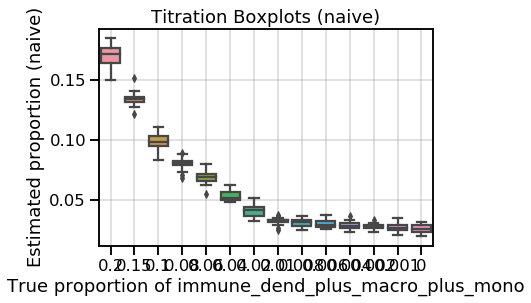

In [21]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

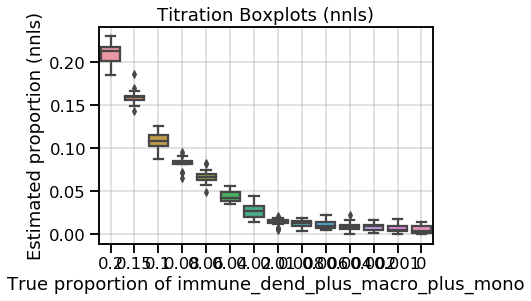

In [22]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )

/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/deconvolution.py:242: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


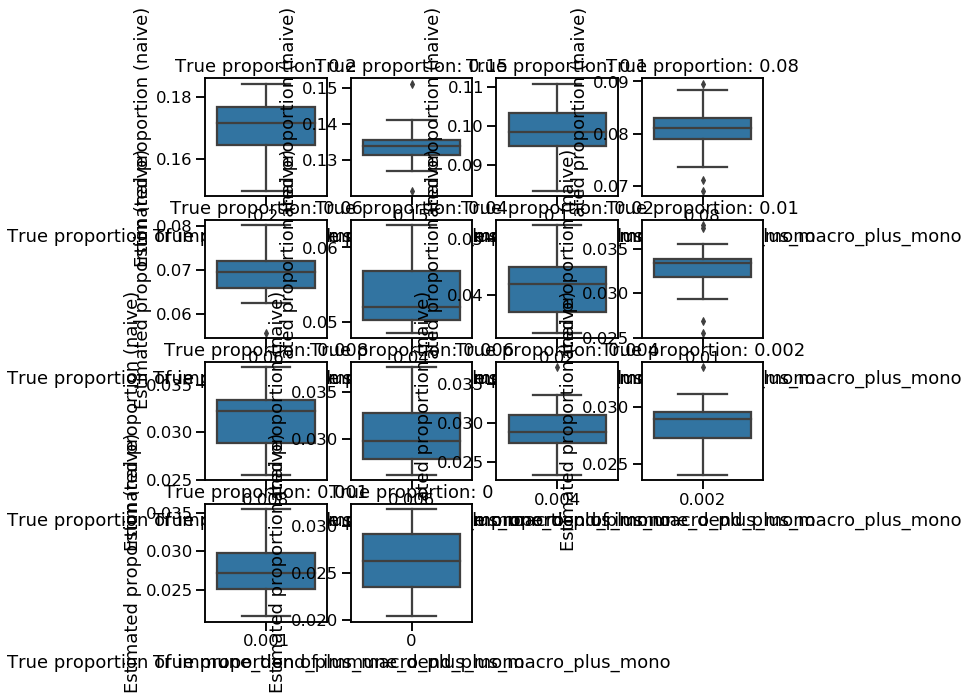

In [23]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_naive,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='naive'
                      )

/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/deconvolution.py:242: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


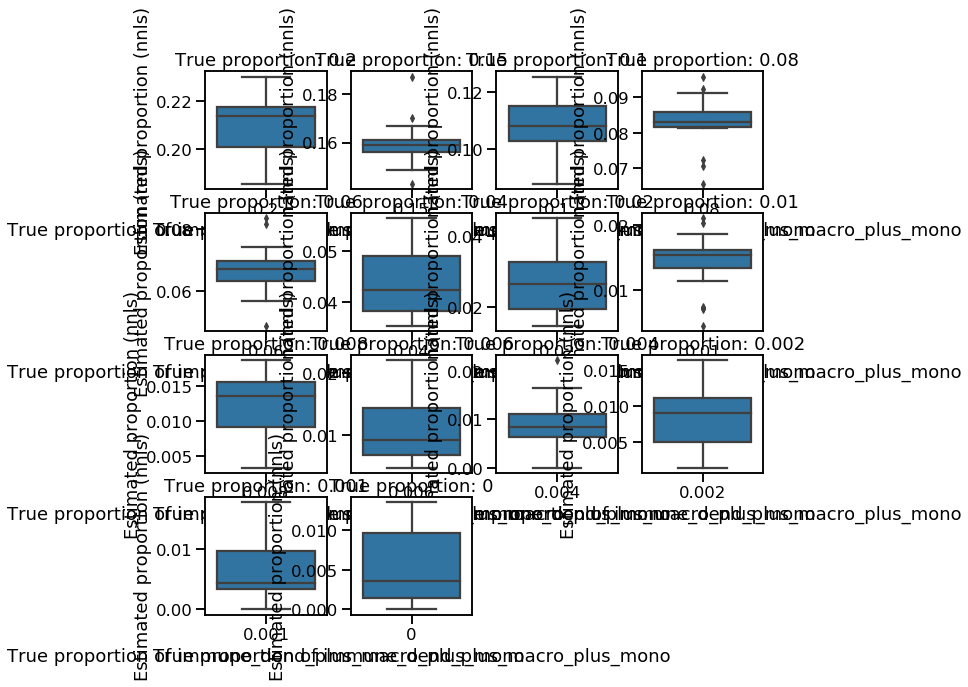

In [24]:

dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=TITRATION_LIST,
                      deconvolution_method_name='nnls'
                      )